# Calculating Chirpiness of a sound signal in `WCA1`

In [1]:
import Pkg
Pkg.activate("..")
using WCA1

 Activating environment at `/mnt/data/L2S/myWCA1/Project.toml`


## Synthetic Linear Chirp

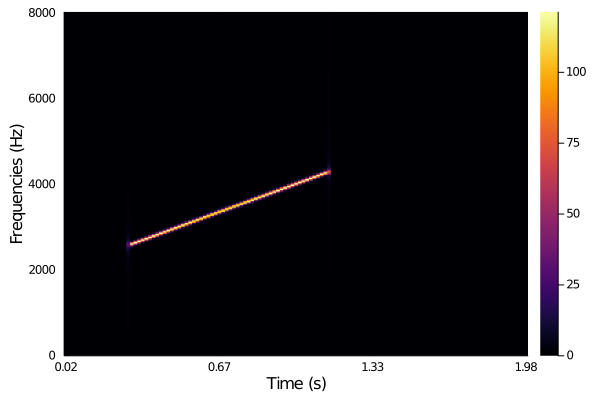

In [2]:
include("../tests/signals.jl")
import DSP
using DSP.Windows

fs = 16000 #Hz
duration = 2 #seconds
x = linear_chirp(fs, duration)
X = stft(x; fs=fs, window=hanning)
show_stft(X)

Now that we have the STFT of our signal, we can calculate the gradient of the signal spectrum.

In [3]:
using ImageFiltering

grad(f) = imgradients(f, KernelFactors.ando3)

S = abs.(X.stft)
dw, dt = grad(S)
V = ifelse.(abs.(dw) .> 1e-3, -dt ./ dw, 0);

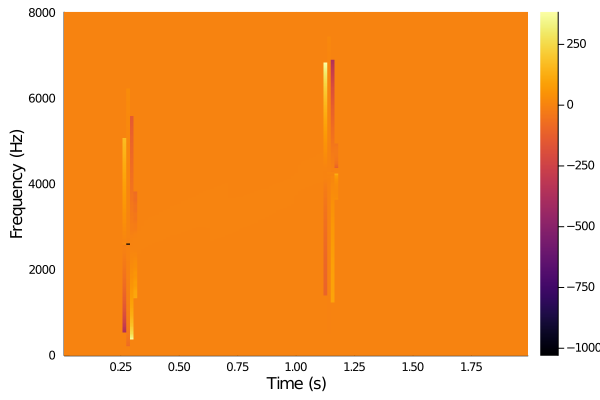

In [4]:
using Plots

function plot_heatmap(M::Matrix{T}; time=nothing, freq=nothing) where {T}
    if (time == nothing || freq == nothing)
        heatmap(M, xaxis="Time (s)", yaxis="Frequency (Hz)")
    else
        heatmap(time, freq, M, xaxis="Time (s)", yaxis="Frequency (Hz)")
    end
end

plot_heatmap(V; time=X.time, freq=X.freq)

Let's try to map the chirpiness into a sigmoid or ReLu function to plot a normalized heatmap

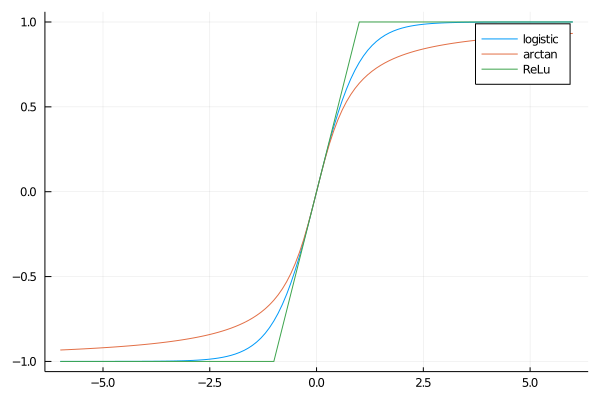

In [17]:
function sigmoid(x, k=1, mode="logistic")
    kx = k * x
    if mode == "logistic"
        return 2/(1+exp(-2*kx)) - 1
    elseif mode == "arctan"
        half_pi = pi / 2
        return atan(half_pi * kx) / half_pi
    elseif mode == "relu"
        if -1. < kx < 1.
            return kx
        else
            return kx > 0 ? +1. : -1.
        end
    else
        println("mode $(mode) not recognized")
        return x
    end
end

# plot sigmoids for k=1
t = collect(-6:0.1:+6)
plot(t, sigmoid.(t, 1, "logistic"), label="logistic")
plot!(t, sigmoid.(t, 1, "arctan"), label="arctan")
plot!(t, sigmoid.(t, 1, "relu"), label="ReLu")

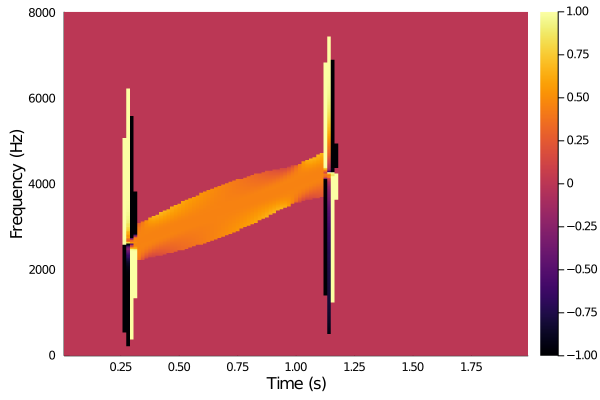

In [11]:
plot_heatmap(sigmoid.(V, 0.5, "logistic"); time=X.time, freq=X.freq)

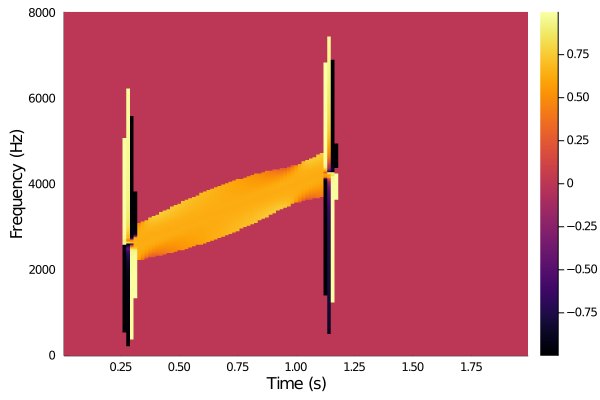

In [6]:
plot_heatmap(sigmoid.(V, 1, "arctan"); time=X.time, freq=X.freq)

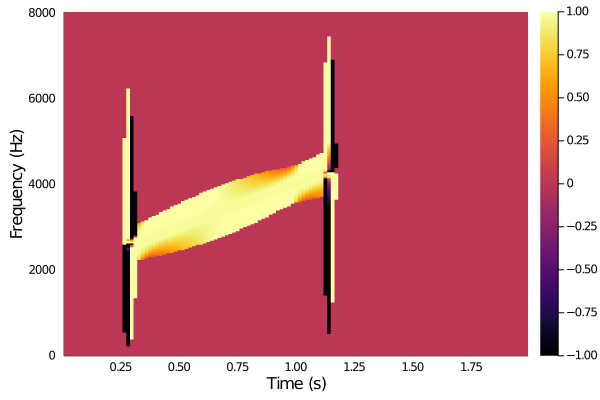

In [7]:
plot_heatmap(sigmoid.(V, 1, "relu"); time=X.time, freq=X.freq)

Let's plot the histogram of the chirpiness values.

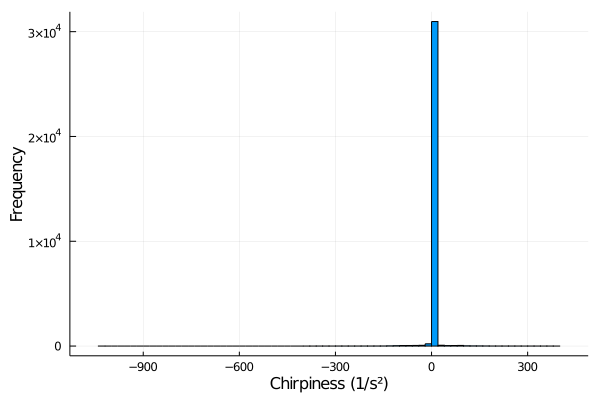

In [8]:
flatten(M) = reshape(M, length(M))
flatV = flatten(V)

histogram(flatV, bins=100, xaxis="Chirpiness (1/s²)", yaxis="Frequency", label="")

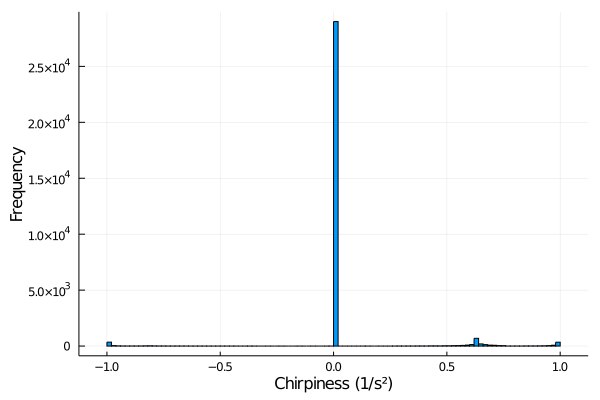

In [9]:
histogram(sigmoid.(flatV, 1, "arctan"), bins=100, xaxis="Chirpiness (1/s²)", yaxis="Frequency", label="")

Let's try to visualize the histogram for non-zero chirpiness

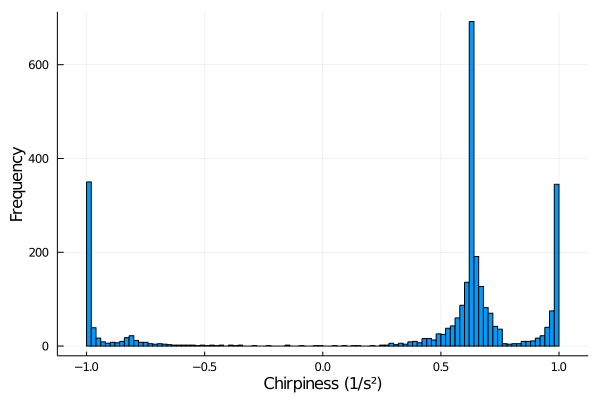

In [10]:
NZV = flatV[abs.(flatV) .> 1e-10]
histogram(sigmoid.(NZV, 1, "arctan"), bins=100, xaxis="Chirpiness (1/s²)", yaxis="Frequency", label="")

Let's now calculate the slopes as in the `lift` module.

In [25]:
function compute_slopes(SS; threshold = 1e-3, args...)
    M = abs.(SS.stft)
    gx, gy = grad(M)
    
    gx = gx * length(SS.freq)
    gy = gy / step(SS.time)
    
    G = similar(M)
    for i in 1:length(M)
        G[i] = abs(gx[i]) > threshold  ? -gy[i]/gx[i] : 0.
    end
    G
end


normalize(x) = (first(x)/last(x)):(step(x)/last(x)):1

rng(t) = last(t) - first(t)

zs(M, νMin, νMax, N) = range(νMin,νMax, length = N)

function compute_slope_matrix(M, νMin, νMax, N = 100; args...)
    Z = zs(M, νMin, νMax, N)
    slopeMatrix = similar(M, Union{Int,Nothing})
    A = round.(Int,(M .- first(Z))*(N-1)/(rng(Z)) .+ 1)
    for i in 1:length(M)
        if first(Z) <= M[i] <= last(Z)
            slopeMatrix[i] = A[i]
        elseif M[i] > last(Z)
                slopeMatrix[i] = nothing#N
        elseif M[i] < first(Z)
                    slopeMatrix[i] = nothing#1
        else
            slopeMatrix[i] = nothing
        end
    end
    slopeMatrix, Z
end


function slopes(SS::STFT, νMin, νMax, N = 100; args...) where {T<:Real}
    G = compute_slopes(SS; args...)
    #M = auto_cut(G; args...)   ### Placeholder for automated slope detection
    compute_slope_matrix(G, νMin, νMax, N)
end

slopes (generic function with 3 methods)

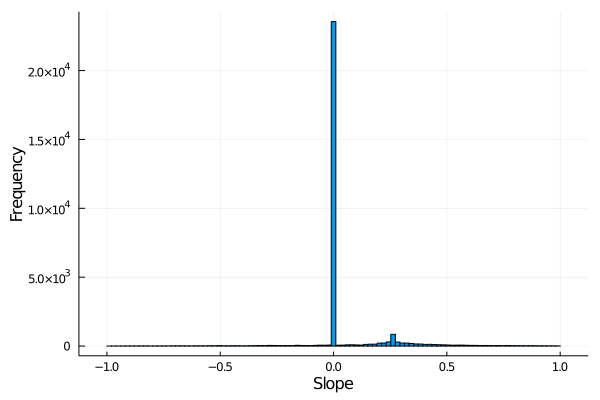

In [36]:
slope, Z = slopes(X, -1, +1, 100)
z = collect(Z)
slope_val = z[Int.(slope[slope .!== nothing])]
histogram(slope_val, bins=Z, xaxis="Slope", yaxis="Frequency", label="")

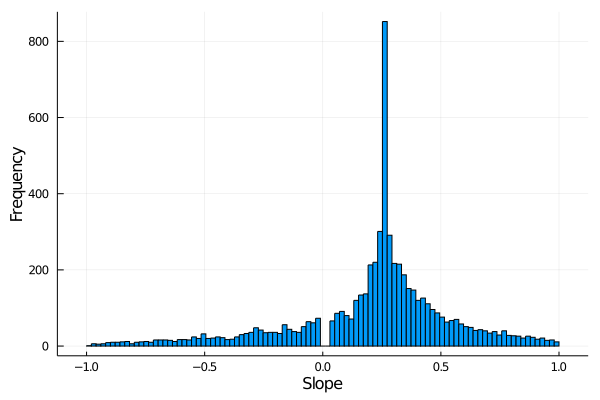

In [45]:
nonzero_slope = slope_val[abs.(slope_val) .> 3e-2]
histogram(nonzero_slope, bins=Z, xaxis="Slope", yaxis="Frequency", label="")